In [2]:
import pandas as pd
import numpy as np
import arxivscraper
from random import randint
import matplotlib.pyplot as plt
import datetime

#### Make authors, papers and authors_paper without rules

WARNING: Running this cell only if you want to extract all the data again, it takes too long

In [3]:
if True:
    # Getting data computer science session
    scraper_cs = arxivscraper.Scraper(category='cs', date_from='2007-01-01',date_until='2011-12-30')
    output = scraper_cs.scrape()
    df = pd.DataFrame.from_dict(output)
    
    # Getting data stat session
#     scraper_stat = arxivscraper.Scraper(category='physics:nucl-th', date_from='2007-01-01',date_until='2017-12-30')
#     outputs = scraper_stat.scrape()
#     df2 = pd.DataFrame.from_dict(outputs)
    
    # generate authors
    authors = []

#     output = output[0:len(outputs)]
    for aut in output:
        for i, a in enumerate(aut['authors']):
            authors.append({'idauthor': f'aoz{(i + randint(1,21)*5)}xyz{(i + randint(1,21))}', 'name': a})

#     for aut in outputs:
#         for i, a in enumerate(aut['authors']):
#             authors.append({'idauthor': f'aoz{(i + randint(1,21)*5)}xyz{(i + randint(1,21))}', 'name': a})

    authors
    
    #Generate papers
    papers = []

    for aut in output:
        papers.append({'idpaper': aut['id'], 'title': aut['title'], 'abstract': aut['abstract'], 'date_create': aut['created'], 'area': aut['categories'], 'authors': aut['authors']})

#     for aut in outputs:
#         papers.append({'idpaper': aut['id'], 'title': aut['title'], 'abstract': aut['abstract'], 'date_create': aut['created'], 'area': aut['categories'], 'authors': aut['authors']})

    papers
    
    # Generate authors_paper
    autor_paper = []

    for p in papers:
        for a in authors:
            if a['name'] in p['authors']:
                autor_paper.append({'idauthor_paper': f'auz{(i + randint(1,21)*5)}ppr{(i + randint(1,21))}', 'author_idauthor': a['idauthor'], 'paper_idpaper': p['idpaper'], 'date_create': p['date_create']})
    autor_paper
    
    # Save .json files
    import json
    with open('../datasets/_authors.json', 'w') as fp:
        json.dump(authors, fp)

    with open('../datasets/_papers.json', 'w') as fp:
        json.dump(papers, fp)

    with open('../datasets/_author_paper.json', 'w') as fp:
        json.dump(autor_paper, fp)

http://export.arxiv.org/oai2?verb=ListRecords&from=2007-01-01&until=2011-12-30&metadataPrefix=arXiv&set=cs
fetching up to  1000 records...
fetching up to  2000 records...
Got 503. Retrying after 30 seconds.
fetching up to  2000 records...
fetching up to  3000 records...
Got 503. Retrying after 30 seconds.
fetching up to  3000 records...
fetching up to  4000 records...
Got 503. Retrying after 30 seconds.
fetching up to  4000 records...
fetching up to  5000 records...
Got 503. Retrying after 30 seconds.
fetching up to  5000 records...
fetching up to  6000 records...
Got 503. Retrying after 30 seconds.
fetching up to  6000 records...
fetching up to  7000 records...
Got 503. Retrying after 30 seconds.
fetching up to  7000 records...
fetching up to  8000 records...
Got 503. Retrying after 30 seconds.
fetching up to  8000 records...
fetching up to  9000 records...
Got 503. Retrying after 30 seconds.
fetching up to  9000 records...
fetching up to  10000 records...
Got 503. Retrying after 30 s

#### Download dataset

#### ** Step initial **
WARNING: This cell should only be executed if it does not have the data on the local machine

In [4]:
if False:
    !wget https://www.dropbox.com/s/s5mysx0b6sp7jvw/authors.json -P ../datasets/
    !wget https://www.dropbox.com/s/ktvn3q2ijfka9zn/authors_paper.json -P ../datasets/
    !wget https://www.dropbox.com/s/jbqvl5htdv41c33/papers.json -P ../datasets/

#### Apply rules

1. Remove papers with only one author
2. All areas that are in year 1 must be in year 2
3. Remove authors who appear in year 1 and do not appear in year 2
4. Remove authors who are only in year 2

In [5]:
if True:
    # load dicts
    import json
    with open('../datasets/_authors.json') as fp:
        authors = json.loads(fp.read())

    with open('../datasets/_papers.json') as fp:
        papers = json.loads(fp.read())

    with open('../datasets/_author_paper.json') as fp:
        autor_paper = json.loads(fp.read())

    # drop single authors
    papers_with_multiple_authors = []

    for p in papers:
        if len(p['authors']) > 1:
            papers_with_multiple_authors.append(p)

    papers = papers_with_multiple_authors

    # Regenerate authors_paper
    autor_paper = []

    for p in papers:
        for a in authors:
            if a['name'] in p['authors']:
                autor_paper.append({'idauthor_paper': f'auz{(randint(1,21)*5)}ppr{(randint(1,21))}', 'author_idauthor': a['idauthor'], 'paper_idpaper': p['idpaper'], 'date_create': p['date_create']})
    len(autor_paper)

    # Save .json files
    import json
    with open('../datasets/_authors.json', 'w') as fp:
        json.dump(authors, fp)

    with open('../datasets/_papers.json', 'w') as fp:
        json.dump(papers, fp)

    with open('../datasets/_author_paper.json', 'w') as fp:
        json.dump(autor_paper, fp)

In [6]:
if True:
    from dateutil.relativedelta import relativedelta
    import datetime
    
    # Creates two auxiliary lists with each year's publications
    year_one = []
    year_two = []
    year_limit = datetime.datetime.strptime("2009-01-01", "%Y-%m-%d").timestamp() * 1000

    for ap in autor_paper:
        dt_c = datetime.datetime.strptime(ap['date_create'], "%Y-%m-%d").timestamp() * 1000
        if dt_c > year_limit:
            year_two.append(ap)
        else:
            year_one.append(ap)

    print(len(autor_paper), len(year_two), len(year_one))

    def verify_author_at_year(id_author, list_year):
        for i in list_year:
            if id_author in i['author_idauthor']:
                return True
        return False

    author_paper_on_two_year = []
    single_ids_author = []
    for ap in autor_paper:
        if ap['author_idauthor'] not in single_ids_author:
            single_ids_author.append(ap['author_idauthor'])
            exists_yer_one = verify_author_at_year(ap['author_idauthor'], year_one)
            exists_yer_two = verify_author_at_year(ap['author_idauthor'], year_two)
            if exists_yer_one and exists_yer_two:
                author_paper_on_two_year.append(ap)

    print(len(author_paper_on_two_year))

    # removes non-published authors within two years

    filter_authors = []

    for a in authors:
        for apty in author_paper_on_two_year:
            if a['idauthor'] in apty['author_idauthor']:
                filter_authors.append(a)
                continue

    print(len(authors), len(filter_authors))


    # removes unused papers 

    filter_papers = []

    for p in papers:
        for apty2 in author_paper_on_two_year:
            if p['idpaper'] in apty2['paper_idpaper']:
                filter_papers.append(p)

    print(len(papers), len(filter_papers))

    # Save .json files
    import json
    with open('../datasets/_authors.json', 'w') as fp:
        json.dump(filter_authors, fp)

    with open('../datasets/_papers.json', 'w') as fp:
        json.dump(filter_papers, fp)

    with open('../datasets/_author_paper.json', 'w') as fp:
        json.dump(author_paper_on_two_year, fp)

1824058 1077411 746647
2495
71733 99764
21380 2495


#### Load dataframes authors

In [7]:
df_authors = pd.read_json('../datasets/_authors.json')
df_authors.drop_duplicates(subset=['idauthor'], keep=False, inplace=True)
df_authors.head()

,idauthor,name
466,aoz95xyz31,navarro
469,aoz53xyz33,schifano
471,aoz101xyz34,tripiccione
472,aoz97xyz38,velasco
1306,aoz112xyz11,wood


#### Load dataframes author_paper

In [8]:
df_author_paper = pd.read_json('../datasets/_author_paper.json')
df_author_paper.drop_duplicates(subset=['author_idauthor', 'date_create', 'paper_idpaper'], keep=False, inplace=True)
df_author_paper.head()

,author_idauthor,date_create,idauthor_paper,paper_idpaper
0,aoz45xyz12,2007-03-30,auz35ppr2,704.0002
1,aoz26xyz17,2007-03-30,auz70ppr11,704.0002
2,aoz55xyz4,2007-03-30,auz40ppr10,704.0002
3,aoz21xyz6,2007-03-30,auz25ppr19,704.0002
4,aoz40xyz14,2007-03-30,auz5ppr20,704.0002


#### Load dataframes paper

In [9]:
df_paper = pd.read_json('../datasets/_papers.json')
df_paper.drop(columns=['authors'], axis=1, inplace=True)
df_paper.drop_duplicates(subset=['area', 'idpaper', 'title'], keep=False, inplace=True)
df_paper.head()

,abstract,area,date_create,idpaper,title
1303,bi-intuitionistic logic is the extension of in...,cs.lo,2007-04-13,704.1707,a cut-free sequent calculus for bi-intuitionis...
1333,on-line chain partition is a two-player game b...,cs.dm,2007-04-13,704.1829,on-line chain partitions of up-growing semi-or...
1481,typing of lambda-terms in elementary and light...,cs.lo cs.pl,2007-04-18,704.2448,light logics and optimal reduction: completene...
1490,a discrete (finite-difference) analogue of dif...,math.gt cs.dm hep-th,2007-04-19,704.2609,a-infinity structure on simplicial complexes
1641,one of the major problems in computational bio...,cs.ai q-bio.qm,2007-04-25,704.3453,an adaptive strategy for the classification of...


#### Extract features with LSA from abstract 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=50000, stop_words="english", use_idf=True, smooth_idf=True)
X = tfidf_vectorizer.fit_transform(df_paper['abstract'])

models = '../models/'

with open(f'{models}_tf_idf_vectorize.pkl', 'wb') as mtfidf:
    joblib.dump(tfidf_vectorizer, mtfidf)

svd = TruncatedSVD(n_components=400, algorithm='randomized',
                   n_iter=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
lsa.fit_transform(X)

with open(f'{models}_lsa.pkl', 'wb') as fin:
    joblib.dump(lsa, fin)

tf_idf = joblib.load(f'{models}_tf_idf_vectorize.pkl')

tf_idf_features = tf_idf.transform(df_paper['abstract'])

lsa = joblib.load(f'{models}_lsa.pkl')

X = lsa.transform(tf_idf_features)

In [12]:
X

array([[  8.96701883e-02,  -2.01966254e-02,   5.81978664e-04, ...,
          9.47793407e-04,  -5.09754275e-03,   1.70262733e-03],
       [  1.00238604e-01,  -2.13825275e-02,   1.05213757e-01, ...,
         -4.24536076e-02,   2.64583839e-02,  -3.93690559e-03],
       [  1.00742752e-01,  -3.74341472e-03,   5.99498959e-02, ...,
         -6.32442111e-04,   2.86327495e-03,  -5.87878335e-05],
       ..., 
       [  2.04706373e-01,  -4.70672888e-02,   1.57459257e-02, ...,
         -1.37426935e-02,   9.87054596e-03,  -4.75231137e-03],
       [  1.03643666e-01,  -3.58730617e-02,  -4.99789877e-02, ...,
         -9.98045555e-03,  -1.44007333e-02,   2.54809364e-03],
       [  1.70576892e-01,  -9.36495387e-02,  -4.31941657e-02, ...,
         -1.81987256e-02,   1.03241490e-02,   8.03742476e-03]])

#### Clustering K-MEANS Sklearn

In [33]:
def kmeans(data):    
    from sklearn.cluster import KMeans
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns; sns.set()

    model = KMeans(n_clusters=2, verbose=False)
    model.fit(data)

    y_kmeans = model.predict(data)
        
    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')

    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

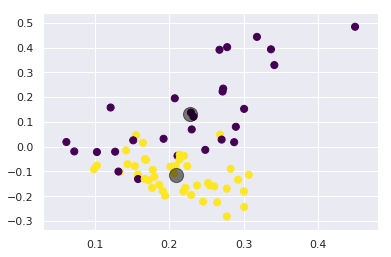

In [34]:
kmeans(X)